In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
#import shap

import sys
sys.path.append('/home/rluser/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS, WS_B
from PreProcessingFunctions import rename_and_convert_to_txt

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:    
    for gpu in gpus:
        tensorflow.config.set_logical_device_configuration(
            gpu,
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC, Precision, Recall
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model


#folder_path = '/home/rluser/thesis_ws/src/RobotData_GRIPA320'
data_folder = '/home/rluser/thesis_ws/src/ML/DATA/1D_Fnew_GRIP_ScalNorm/'

def load_data(data_folder):
    X_data = []
    y_data = []
    # Get list of all .npz files in the data folder
    npz_files = [file for file in os.listdir(data_folder) if file.endswith('.npz')]
    
    # Load data from each .npz file
    for file in npz_files:
        file_path = os.path.join(data_folder, file)
        data = np.load(file_path)
        X_data.append(data['X'])  # Assuming X_data is stored under 'X' key in the .npz file
        y_data.append(data['y'])  # Assuming y_data is stored under 'y' key in the .npz file
        data.close()
    
    # Convert lists to NumPy arrays
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

2024-06-12 01:12:57.683547: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 01:12:58.554994: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-12 01:12:59.238436: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-12 01:12:59.280081: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

X_data shape: (1465, 800)
y_data shape: (1465,)
X_data.[0] shape:  (800,)
TOTAL DATA: 1465  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (879, 800)    ||  Dimensions of y_train: (879,)
Dimensions of X_test:  (293, 800)    ||  Dimensions of y_test:  (293,)
Dimensions of X_val:   (293, 800)    ||  Dimensions of y_val:   (293,)


# 1 CONVs

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-06-04 18:03:47.381152: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 18:03:47.381638: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 18:03:47.381914: I e

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 391, 128)       │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 195, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 24960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,597,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,600,257 (6.10 MB)

 Trainable params: 1,600,257 (6.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/22


I0000 00:00:1717517028.531796   60045 service.cc:145] XLA service 0x7153a8007bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717517028.531826   60045 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-06-04 18:03:48.558012: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-04 18:03:48.710377: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 1/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5000 - loss: 0.6994

I0000 00:00:1717517029.529984   60045 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.5008 - loss: 0.7798 - val_accuracy: 0.5802 - val_loss: 0.6830
Epoch 2/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6354 - loss: 0.6374 - val_accuracy: 0.6689 - val_loss: 0.5618
Epoch 3/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6963 - loss: 0.5615 - val_accuracy: 0.7065 - val_loss: 0.5281
Epoch 4/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7447 - loss: 0.5255 - val_accuracy: 0.7031 - val_loss: 0.5199
Epoch 5/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7266 - loss: 0.4908 - val_accuracy: 0.7577 - val_loss: 0.5077
Epoch 6/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7616 - loss: 0.4775 - val_accuracy: 0.6689 - val_loss: 0.5418
Epoch 7/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7596 - loss: 0.4586 - val_accuracy: 0.7065 - val_loss: 0.5775
Epoch 8/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7449 - loss: 0.4765 - val_accuracy: 0.7235 - val_loss: 0.5324
E

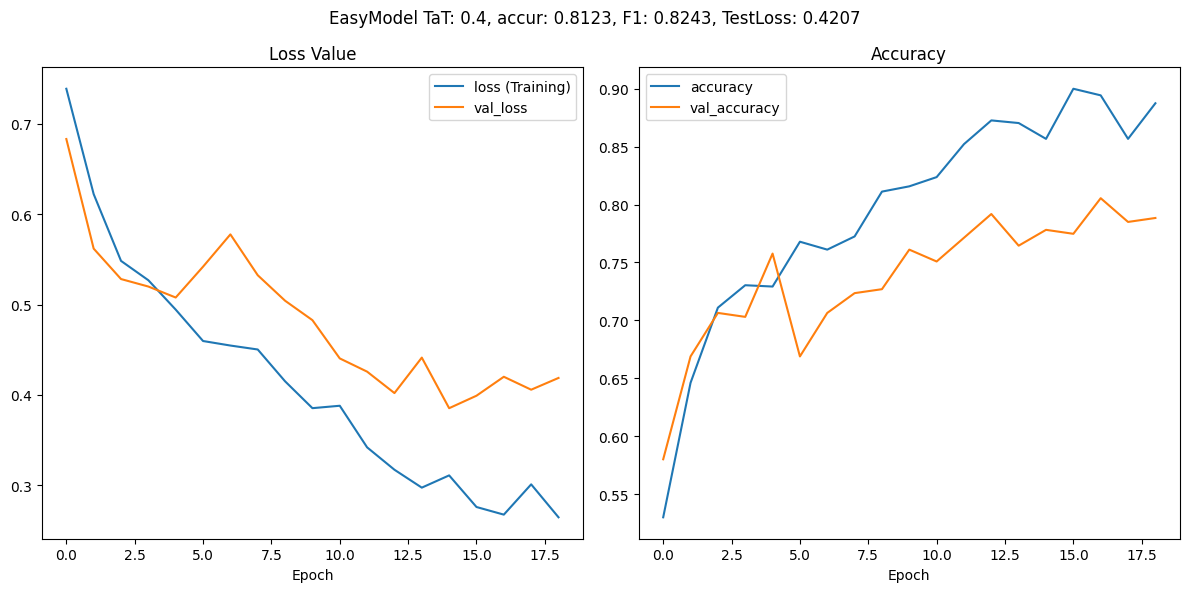

Train loss: 0.26473814249038696
Test val_loss: 0.4188101887702942
Train accuracy: 0.8873720169067383
Accuracy Score: 0.8122866894197952
F1 Score: 0.8242811501597445
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.79      0.80       138
         1.0       0.82      0.83      0.82       155

    accuracy                           0.81       293
   macro avg       0.81      0.81      0.81       293
weighted avg       0.81      0.81      0.81       293



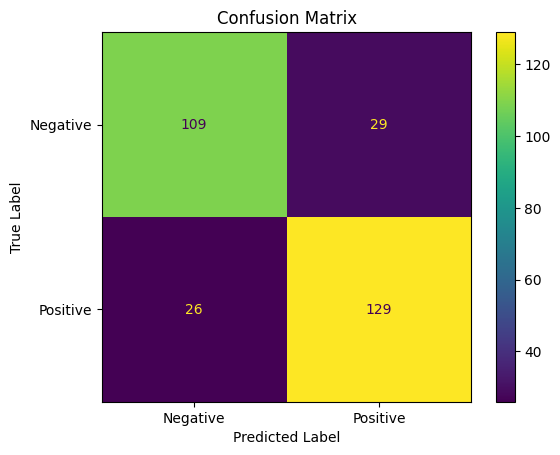

In [2]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=20, strides=2, activation='relu', input_shape=(WS_B, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    #model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model_name = "1D_easy1Conv"
model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=22, batch_size=64, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

# <span style="color:red;"> PLOT F1 SCORE AND F1 WRT ALL the THRESHOLDS</span>


# 2 CONVs 

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 396, 256)       │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 393, 128)       │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,337 (556.00 KB)

 Trainable params: 142,337 (556.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.5109 - loss: 0.6935 - val_accuracy: 0.6075 - val_loss: 0.6775
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6448 - loss: 0.6551 - val_accuracy: 0.6655 - val_loss: 0.6402
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6632 - loss: 0.6256 - val_accuracy: 0.6246 - val_loss: 0.6034
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6454 - loss: 0.5960 - val_accuracy: 0.7133 - val_loss: 0.5741
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7100 - loss: 0.5714 - val_accuracy: 0.7235 - val_loss: 0.5441
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6731 - loss: 0.5741 - val_accuracy: 0.7304 - val_loss: 0.5284
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7293 - loss: 0.5299 - val_accuracy: 0.7031 - val_loss: 0.5375
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6943 - loss: 0.5385 - val_accuracy: 0.7270 - 

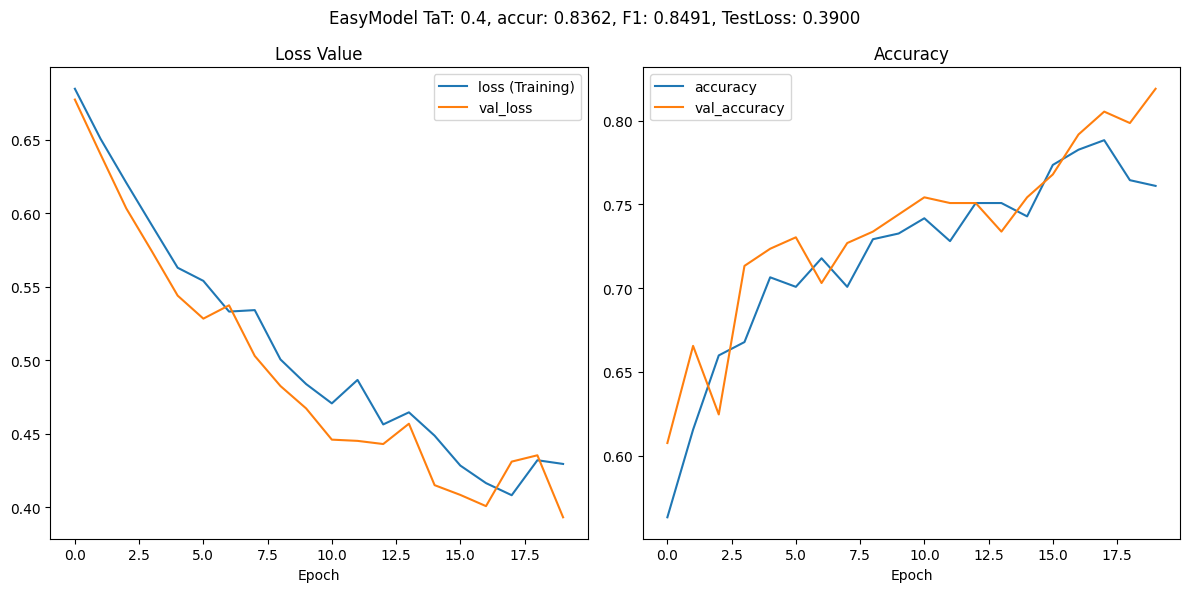

Train loss: 0.4295315146446228
Test val_loss: 0.39322230219841003
Train accuracy: 0.7610921263694763
Accuracy Score: 0.8361774744027304
F1 Score: 0.8490566037735849
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.80      0.82       138
         1.0       0.83      0.87      0.85       155

    accuracy                           0.84       293
   macro avg       0.84      0.83      0.83       293
weighted avg       0.84      0.84      0.84       293



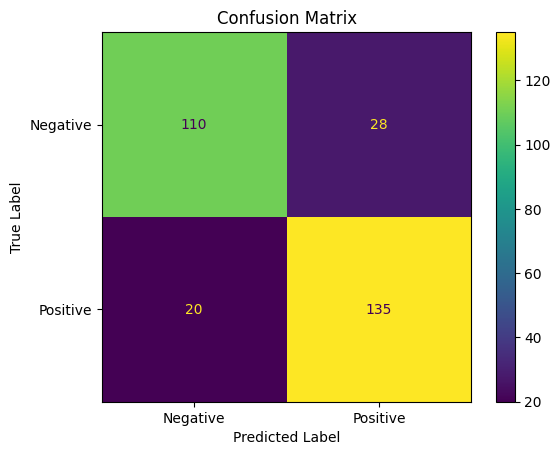

In [3]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(filters=256, kernel_size=10, strides=2, activation='relu', input_shape=(WS_B, 1)))
    #model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
    model.add(GlobalMaxPooling1D())
    # model.add(MaxPooling1D(pool_size=2))
    # model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

# 3 CONVs

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 198, 64)        │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 99, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 48, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 47, 256)        │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,417 (517.25 KB)

 Trainable params: 132,417 (517.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.5392 - loss: 0.6886 - val_accuracy: 0.5427 - val_loss: 0.6756
Epoch 2/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6071 - loss: 0.6670 - val_accuracy: 0.6246 - val_loss: 0.6498
Epoch 3/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6488 - loss: 0.6290 - val_accuracy: 0.6348 - val_loss: 0.6346
Epoch 4/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6584 - loss: 0.6207 - val_accuracy: 0.6792 - val_loss: 0.5841
Epoch 5/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6752 - loss: 0.5705 - val_accuracy: 0.6997 - val_loss: 0.5393
Epoch 6/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6922 - loss: 0.5515 - val_accuracy: 0.6997 - val_loss: 0.5159
Epoch 7/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6910 - loss: 0.5322 - val_accuracy: 0.7235 - val_loss: 0.4807
Epoch 8/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7097 - loss: 0.5092 - val_accuracy: 0.7440 - val_los

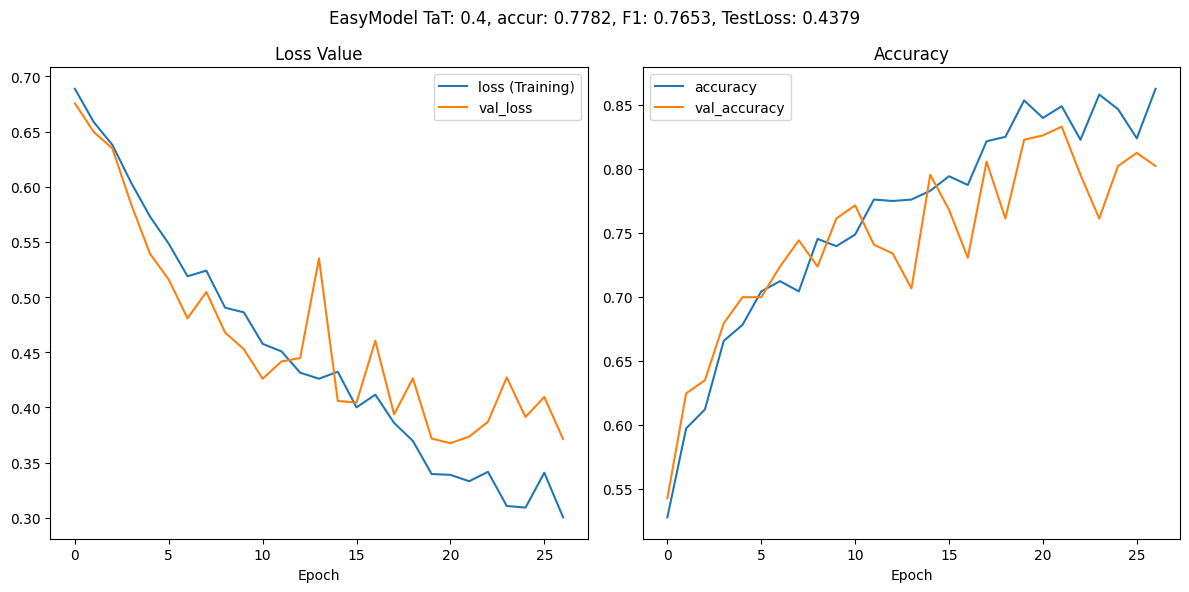

Train loss: 0.3003922700881958
Test val_loss: 0.3713213801383972
Train accuracy: 0.8623435497283936
Accuracy Score: 0.7781569965870307
F1 Score: 0.7653429602888087
Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.88      0.79       138
         1.0       0.87      0.68      0.77       155

    accuracy                           0.78       293
   macro avg       0.79      0.78      0.78       293
weighted avg       0.80      0.78      0.78       293



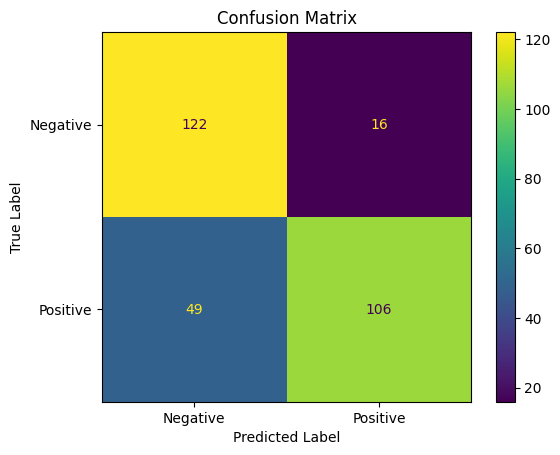

In [6]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=10, strides=4, activation='relu', input_shape=(WS_B, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=4, strides=2, activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(256, kernel_size=2, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid')) 

    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=38, batch_size=64, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

# 4 CONVs or Still "COMPLEX"

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)              │ (None, 396, 256)       │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 198, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 98, 256)        │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 98, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 45, 128)        │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 19, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 630,081 (2.40 MB)

 Trainable params: 630,081 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/34
23/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5313 - loss: 0.6991

2024-06-04 18:05:56.844950: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.5288 - loss: 0.6989 - val_accuracy: 0.5563 - val_loss: 0.6849
Epoch 2/34
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5850 - loss: 0.6805 - val_accuracy: 0.6109 - val_loss: 0.6478
Epoch 3/34
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6262 - loss: 0.6381 - val_accuracy: 0.6451 - val_loss: 0.6104
Epoch 4/34
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6761 - loss: 0.5920 - val_accuracy: 0.6007 - val_loss: 0.6462
Epoch 5/34
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6413 - loss: 0.5908 - val_accuracy: 0.7406 - val_loss: 0.4807
Epoch 6/34
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7468 - loss: 0.5004 - val_accuracy: 0.6382 - val_loss: 0.6011
Epoch 7/34
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7215 - loss: 0.5283 - val_accuracy: 0.7918 - val_loss: 0.3829
Epoch 8/34
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8068 - loss: 0.4091 - val_accuracy: 0.7543 - val_loss: 0

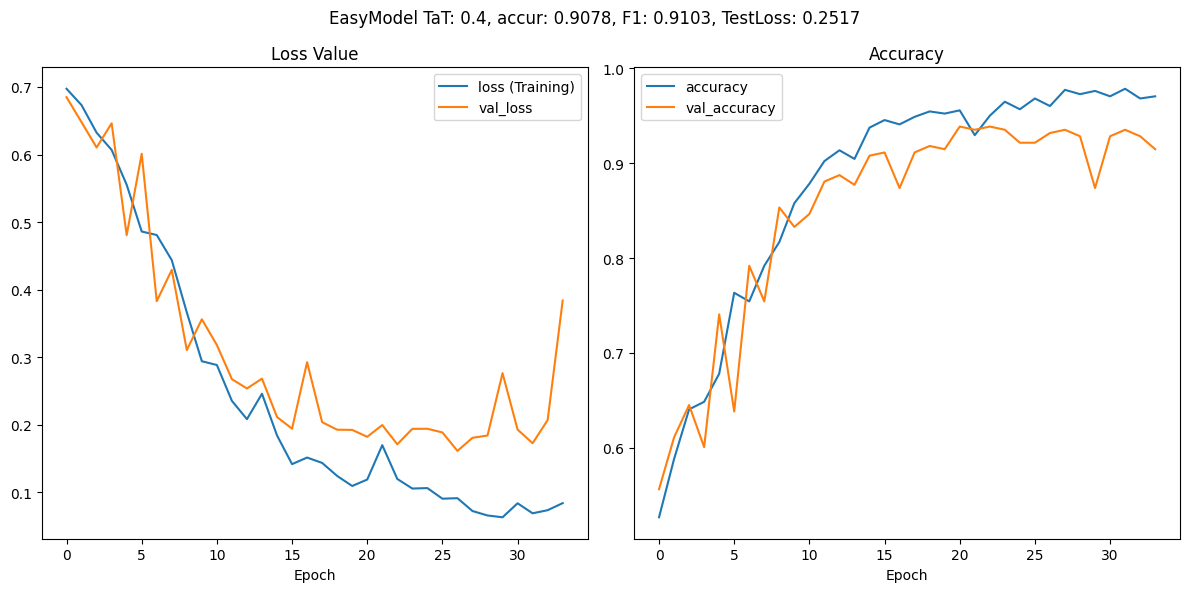

Train loss: 0.08400411158800125
Test val_loss: 0.3839053511619568
Train accuracy: 0.9704209566116333
Accuracy Score: 0.9078498293515358
F1 Score: 0.9102990033222591
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.93      0.91       138
         1.0       0.94      0.88      0.91       155

    accuracy                           0.91       293
   macro avg       0.91      0.91      0.91       293
weighted avg       0.91      0.91      0.91       293



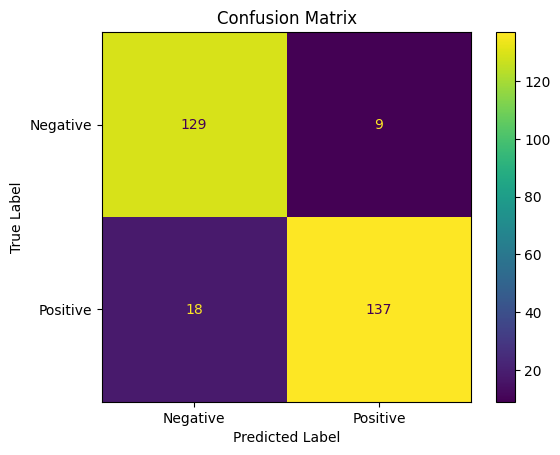

In [9]:
def build_easyModel():
    model = Sequential()
    
    model.add(Conv1D(filters=256, kernel_size=10, strides=2, activation='relu', input_shape=(WS_B, 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=256, kernel_size=4, strides=2, activation='relu')) #LeakyReLU(alpha=0.001)
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(filters=128, kernel_size=10, strides=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model.add(GlobalMaxPooling1D())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=34, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

# 5 CONVS